In [ ]:
!pip install torch
!pip install torchvision

In [0]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.nn import init
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch import distributions as D

from itertools import cycle
from functools import reduce
from operator import __or__
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [0]:
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import PIL
import imageio
import sys
import math
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from IPython import display

In [4]:
use_cuda = torch.cuda.is_available()
seed=1
torch.manual_seed(seed)

### Utils

In [0]:
def create_dataset(n_samples=1000, noise=0.1, random_state=0):

    datasets = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)

    X, y = datasets
    X = StandardScaler().fit_transform(X)
    X = X.astype(float)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots()
    ax.set_title("Input data")

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
                edgecolors='k')

    ax.set_xticks(())
    ax.set_yticks(())

    plt.tight_layout()
    plt.show()

    return datasets

In [0]:
from torch.utils import data

class HalfMoon(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, points, labels):
    'Initialization'
    self.labels = labels
    self.points = points

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.labels)

  def __getitem__(self, index):
    'Generates one sample of data'
    # Select sample
    X = self.points[index]
    y = self.labels[index]

    return X, y, index

class ActiveMoon:
  def __init__(self, dataset, use_cuda, valid_ratio=.4, batch_size=64, labels_per_class=10):
    self.use_cuda = use_cuda
    self.batch_size = batch_size
    self.labels_per_class = labels_per_class

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    X, y = datasets
    X = StandardScaler().fit_transform(X)
    X = X.astype(float)
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=valid_ratio, random_state=42)
    
    self.X_train = X_train
    self.X_valid = X_valid
    self.y_train = y_train
    self.y_valid = y_valid

    self.train_len = len(y_train)

    # Randomly pick 10 points for each class as the first label training data
    indices = np.arange(self.train_len)
    np.random.shuffle(indices)
    self.labelled_indices = np.hstack([list(filter(lambda idx: y_train[idx] == i, indices))[:labels_per_class] for i in range(2)])
    self.unlabelled_indices = np.setdiff1d(np.arange(self.train_len), 
                                           self.labelled_indices)

    self.moon_train = HalfMoon(X_train, y_train)
    self.moon_valid = HalfMoon(X_valid, y_valid)

  def get_valid(self):
    'Get data for validation'
    return torch.utils.data.DataLoader(self.moon_valid, batch_size=self.batch_size, num_workers=2, pin_memory=self.use_cuda)

  def get_next_train(self, acquired_idx=None):
    'Get training data for next active learning loop'

    # If there are acquired data from last loop, update them (index of the data only)
    if acquired_idx is not None:
      self.labelled_indices = np.concatenate((self.labelled_indices, acquired_idx), axis=None)
      self.unlabelled_indices = np.setdiff1d(np.arange(self.train_len), self.labelled_indices)
    
    labelled_indices = torch.from_numpy(self.labelled_indices)
    unlabelled_indices = torch.from_numpy(self.unlabelled_indices)

    labelled = torch.utils.data.DataLoader(self.moon_train, batch_size=self.batch_size, 
                                           num_workers=2, pin_memory=self.use_cuda,
                                           sampler=SubsetRandomSampler(labelled_indices))
    unlabelled = torch.utils.data.DataLoader(self.moon_train, batch_size=self.batch_size, 
                                             num_workers=2, pin_memory=self.use_cuda,
                                             sampler=SubsetRandomSampler(unlabelled_indices))
    return labelled, unlabelled

  def get_xyuv_for_printing(self, labelled, unlabelled):
    'Get data for plotting the moons'
    x_lab = np.array([])
    y_lab = np.array([])
    u_unlab = np.array([])
    v_unlab = np.array([])
    for (x, y, _) in labelled:
        x_lab = np.vstack([x_lab, x.numpy()]) if x_lab.size else x.numpy()
        y_lab = np.concatenate((y_lab, y.numpy()), axis=None) if y_lab.size else y.numpy()
    for (u, v, _) in unlabelled:
        u_unlab = np.vstack([u_unlab, u.numpy()]) if u_unlab.size else u.numpy()
        v_unlab = np.concatenate((v_unlab, v.numpy()), axis=None) if v_unlab.size else v.numpy()

    return self.X_train, self.X_valid, self.y_train, self.y_valid, x_lab, y_lab, u_unlab, v_unlab


### Model

In [0]:
class M2(nn.Module):
  def __init__(self, x_dim=784, y_dim=10, z_dim=32, 
                     h_en_dim=[256, 128], h_de_dim=[128, 256], 
                     h_cls_dim=[256, 128]):
    super(M2, self).__init__()

    self.x_dim = x_dim
    self.y_dim = y_dim
    self.z_dim = z_dim

    en_neurons = [x_dim + y_dim, *h_en_dim]
    de_neurons = [y_dim + z_dim, *h_de_dim]
    cls_neurons = [x_dim, *h_cls_dim]

    en_linear_layers = [nn.Linear(en_neurons[i-1], en_neurons[i]) for i in range(1, len(en_neurons))]
    de_linear_layers = [nn.Linear(de_neurons[i-1], de_neurons[i]) for i in range(1, len(de_neurons))]
    cls_linear_layers = [nn.Linear(cls_neurons[i-1], cls_neurons[i]) for i in range(1, len(cls_neurons))]

    # For encoder - q(z|x,y)
    self.en_hidden = nn.ModuleList(en_linear_layers)
    self.mu = nn.Linear(h_en_dim[-1], z_dim)
    self.log_var = nn.Linear(h_en_dim[-1], z_dim)

    # For decoder - p(x|y,z)
    self.de_hidden = nn.ModuleList(de_linear_layers)
    self.reconstruction_mu = nn.Linear(h_de_dim[-1], x_dim)
    self.reconstruction_log_var = nn.Linear(h_de_dim[-1], x_dim)

    # For classifier - q(y|x)
    self.cls_hidden = nn.ModuleList(cls_linear_layers)
    self.logits = nn.Linear(h_cls_dim[-1], y_dim)

  def encode(self, x, y):
    h = torch.cat([x, y], dim=1)
    for layer in self.en_hidden:
        h = F.relu(layer(h))

    mu = self.mu(h)
    log_var = F.softplus(self.log_var(h))

    return self.reparameterize(mu, log_var), mu, log_var

  def reparameterize(self, mu, logvar):
    eps = Variable(torch.randn(mu.size()))
    if mu.is_cuda:
        eps = eps.cuda()

    std = torch.exp(0.5*logvar)
    return mu + eps*std

  def decode(self, y, z):
    h = torch.cat([y, z], dim=1)
    for layer in self.de_hidden:
        h = F.relu(layer(h))
    mu = self.reconstruction_mu(h)
    log_var = self.reconstruction_log_var(h)
    return mu, log_var

  def classify(self, x, apply_softmax=True):
    for layer in self.cls_hidden:
        x = F.relu(layer(x))
    logits = self.logits(x)
    if not apply_softmax:
      return logits
    probs = F.softmax(logits, dim=-1)
    return probs

  def sample(self, y, z):
    y = y.float()
    x_mu, x_log_var = self.decode(y, z)
    return self.reparameterize(x_mu, x_log_var)

  # Calculating ELBO (Both labelled or unlabelled)
  def forward(self, x, y=None, in_batch=True):
    labelled = False if y is None else True

    xs, ys = (x, y)
    # Duplicating samples and generate labels if not labelled
    if not labelled:
      batch_size = xs.size(0)
      ys = torch.from_numpy(np.arange(self.y_dim))
      ys = ys.view(-1,1).repeat(1, batch_size).view(-1)
      ys = F.one_hot(ys, self.y_dim)
      ys = Variable(ys.float())
      ys = ys.cuda() if xs.is_cuda else ys
      xs = xs.repeat(self.y_dim, 1)
    
    # Reconstruction
    zs, z_mu, z_log_var = self.encode(xs, ys)
    x_mu, x_log_var = self.decode(ys, zs)

    # p(x|y,z)
    px_yz = D.normal.Normal(x_mu, torch.exp(0.5*x_log_var))
    px_yz = D.independent.Independent(px_yz, 1)
    loglikelihood = px_yz.log_prob(xs)

    # p(y)
    logprior_y = -math.log(self.y_dim)

    # KL(q(z|x,y)||p(z))
    p_z = D.normal.Normal(torch.zeros_like(zs), torch.ones_like(zs))
    p_z = D.independent.Independent(p_z, 1)
    q_z = D.normal.Normal(z_mu, torch.exp(0.5*z_log_var))
    q_z = D.independent.Independent(q_z, 1)
    kl = D.kl.kl_divergence(q_z, p_z)

    # ELBO : -L(x,y)
    neg_L = loglikelihood + logprior_y - kl

    if labelled:
      return torch.mean(neg_L)

    prob_y = self.classify(x)

    neg_L = neg_L.view_as(prob_y.t()).t()

    # H(q(y|x)) and sum over all labels
    H = -torch.sum(torch.mul(prob_y, torch.log(prob_y + 1e-8)), dim=-1)
    neg_L = torch.sum(torch.mul(prob_y, neg_L), dim=-1)

    # ELBO : -U(x)
    neg_U = neg_L + H

    if in_batch:
      return torch.mean(neg_U)
    else:
      return neg_U

In [0]:
x_dim=2 
y_dim=2 
# z_dim=32
# h_en_dim=[256, 128]
# h_de_dim=[128, 256]
# h_cls_dim=256
z_dim=4
h_en_dim=[8, 16, 8]
h_de_dim=[8, 16, 8]
h_cls_dim=[8, 16, 8, 4]

# model = M2(x_dim, y_dim, z_dim, h_en_dim, h_de_dim, h_cls_dim)

In [0]:
def train_one_step(current_AL_loop, epoch, model, alpha, optimizer, labelled, unlabelled):
  model.train()
  total_loss, accuracy = (0, 0)
  for (x, y, l_idx), (u, _, u_idx) in zip(cycle(labelled), unlabelled):
    y = F.one_hot(y, num_classes=y_dim)
    optimizer.zero_grad()
    # Wrap in variables
    x, y, u = Variable(x.float()), Variable(y.float()), Variable(u.float())

    if use_cuda:
      x, y = x.cuda(), y.cuda()
      u = u.cuda()

    L = -model(x, y)
    U = -model(u)

    # Add auxiliary classification loss q(y|x)
    prob_y = model.classify(x)
    
    # cross entropy
    classication_loss = -torch.sum(y * torch.log(prob_y + 1e-8), dim=1).mean()

    J_alpha = L + U + alpha * classication_loss

    J_alpha.backward()
    optimizer.step()
    
    total_loss += J_alpha.item()
    accuracy += torch.mean((torch.max(prob_y, 1)[1].data == torch.max(y, 1)[1].data).float()).item()

  # display.clear_output(wait=False)
  m = len(unlabelled)
  print("Active Learning Loop number: {}, Epoch: {}".format(current_AL_loop, epoch))
  print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))
  return total_loss / m, accuracy / m


def test(current_AL_loop, epoch, model, alpha, validation):

  model.eval()

  total_loss, accuracy = (0, 0)
  
  for x, y, _ in validation:
    y = F.one_hot(y, num_classes=y_dim)
    x, y = Variable(x.float()), Variable(y.float())

    if use_cuda:
      x, y = x.cuda(), y.cuda()

    L = -model(x, y)
    U = -model(x)

    prob_y = model.classify(x)
    classication_loss = -torch.sum(y * torch.log(prob_y + 1e-8), dim=1).mean()

    J_alpha = L + U + alpha * classication_loss

    total_loss += J_alpha.item()

    _, pred_idx = torch.max(prob_y, 1)
    _, lab_idx = torch.max(y, 1)
    accuracy += torch.mean((pred_idx == lab_idx).float()).item()

  m = len(validation)
  print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))
  return total_loss / m, accuracy / m

def draw_samples(n=10):
  model.eval()
  z = Variable(torch.randn(n, z_dim))

  y_ = np.array([0]*(n//2) + [1] * (n - n//2))
  y = torch.from_numpy(y_)
  y = Variable(F.one_hot(y, num_classes=y_dim).float())

  if use_cuda:
      z, y = z.cuda(), y.cuda()

  x = model.sample(y, z)
  samples = x.data.view(-1, 2).cpu().numpy()

  return samples, y_

### Acquisition Functions

In [0]:
def acquisition_random(model, unlabelled, n_new=20):
  """
  Input: model, unlablled data, and the number of data to acquire

  Output: 
    the acquired data point, 
    the acquired data label, 
    and the acquired data index from the Unlabelled set
  """

  all_idx = np.array([])
  all_u = np.array([])
  all_v = np.array([])
  for u, v, u_idx in unlabelled:
    all_idx = np.concatenate((all_idx, u_idx.numpy()), axis=None) if all_idx.size else u_idx.numpy()
    all_u = np.vstack([all_u, u.numpy()]) if all_u.size else u.numpy()
    all_v = np.concatenate((all_v, v.numpy()), axis=None) if all_v.size else v.numpy()

  if len(all_idx) == 0:
    return None
  elif len(all_idx) < n_new:
    n_new = len(all_idx)

  indices = np.arange(len(all_idx))
  np.random.shuffle(indices)
  acquired_idx = indices[:n_new]

  return all_u[acquired_idx], all_v[acquired_idx], all_idx[acquired_idx]


def acquisition_elbo_px(model, unlabelled, n_new=20):
  """
  Input: model, unlablled data, and the number of data to acquire

  Output: 
    the acquired data point, 
    the acquired data label, 
    and the acquired data index from the Unlabelled set
  """

  model.eval()

  all_elbo = np.array([])
  all_u = np.array([])
  all_v = np.array([])
  all_idx = np.array([])
  for u, v, u_idx in unlabelled:
    all_idx = np.concatenate((all_idx, u_idx.numpy()), axis=None) if all_idx.size else u_idx.numpy()
    all_u = np.vstack([all_u, u.numpy()]) if all_u.size else u.numpy()
    all_v = np.concatenate((all_v, v.numpy()), axis=None) if all_v.size else v.numpy()
    # Wrap in variables
    u = Variable(u.float())

    if use_cuda:
      u = u.cuda()

    elbo = model(u, in_batch=False)
    all_elbo = np.concatenate((all_elbo, elbo.data.cpu().numpy()), axis=None) if all_elbo.size else elbo.data.cpu().numpy()

  if len(all_idx) == 0:
    return None
  elif len(all_idx) < n_new:
    n_new = len(all_idx)

  acquired_idx = np.argsort(all_elbo)[:n_new]

  return all_u[acquired_idx], all_v[acquired_idx], all_idx[acquired_idx]

### Main Active Learning Loop

In [0]:
def train_each_AL_loop(current_AL_loop, epochs, model, alpha, optimizer, labelled, unlabelled, validation, acq_size):
    'Single Loop for training one model at a given Active Learning dataset'
    train_loss=[]
    test_loss=[]

    train_accuracy=[]
    test_accuracy=[]

    # epoch = 0
    # last_train_l = -10
    # not_done = True

    # Train the new model till finish
    for epoch in range(1, epochs + 1):
    # while not_done:
    #     epoch += 1
        train_l, train_acc = train_one_step(current_AL_loop, epoch, model, alpha, optimizer, labelled, unlabelled)
        test_l, test_acc = test(current_AL_loop, epoch, model, alpha, validation)

        train_loss.append(train_l)
        test_loss.append(test_l)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        # if abs(train_l - last_train_l) <= 0.001:
        #     not_done = False
        # last_train_l = train_l

        if epoch % 100 == 0:
            plt.title('Train Loss')
            plt.plot(train_loss)
            plt.show()

            plt.title('Test Loss')
            plt.plot(test_loss)
            plt.show()

            plt.title('Train Accuracy')
            plt.plot(train_accuracy)
            plt.show()

            plt.title('Test Accuray')
            plt.plot(test_accuracy)
            plt.show()

            # sample_x, sample_y = draw_samples()
    
    # Data acquisition
    # acquired_X, acquired_y, acquired_idx = acquisition_random(model, unlabelled, n_new=acq_size)
    acquired_X, acquired_y, acquired_idx = acquisition_elbo_px(model, unlabelled, n_new=acq_size)
    return acquired_X, acquired_y, acquired_idx, test_accuracy[-1]

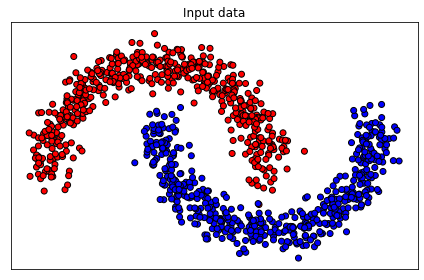

##################### AL Loop 1 #######################
Active Learning Loop number: 1, Epoch: 1
[Train]		 J_a: 9.62, accuracy: 0.50
[Validation]	 J_a: 9.45, accuracy: 0.55
Active Learning Loop number: 1, Epoch: 2
[Train]		 J_a: 9.57, accuracy: 0.50
[Validation]	 J_a: 9.42, accuracy: 0.55
Active Learning Loop number: 1, Epoch: 3
[Train]		 J_a: 9.48, accuracy: 0.50
[Validation]	 J_a: 9.37, accuracy: 0.55
Active Learning Loop number: 1, Epoch: 4
[Train]		 J_a: 9.45, accuracy: 0.50
[Validation]	 J_a: 9.33, accuracy: 0.55
Active Learning Loop number: 1, Epoch: 5
[Train]		 J_a: 9.42, accuracy: 0.50
[Validation]	 J_a: 9.29, accuracy: 0.55
Active Learning Loop number: 1, Epoch: 6
[Train]		 J_a: 9.33, accuracy: 0.50
[Validation]	 J_a: 9.26, accuracy: 0.55
Active Learning Loop number: 1, Epoch: 7
[Train]		 J_a: 9.33, accuracy: 0.50
[Validation]	 J_a: 9.23, accuracy: 0.55
Active Learning Loop number: 1, Epoch: 8
[Train]		 J_a: 9.25, accuracy: 0.50
[Validation]	 J_a: 9.20, accuracy: 0.55
Active L

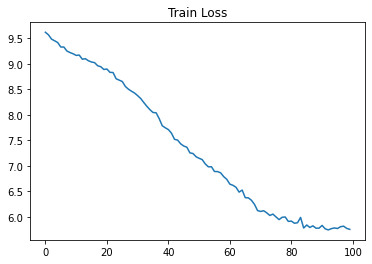

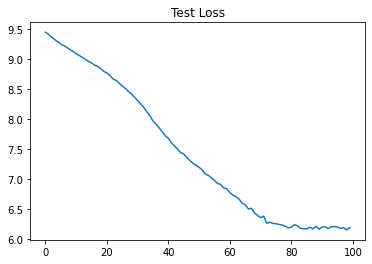

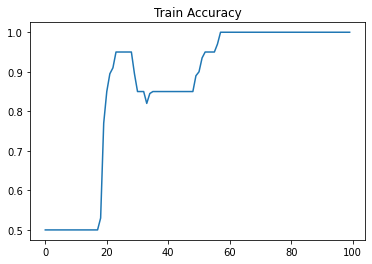

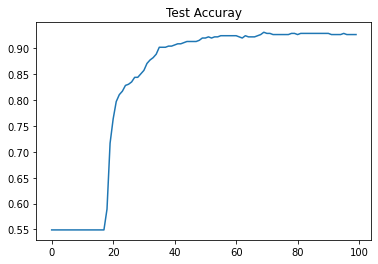

Active Learning Loop number: 1, Epoch: 101
[Train]		 J_a: 5.79, accuracy: 1.00
[Validation]	 J_a: 6.23, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 102
[Train]		 J_a: 5.89, accuracy: 1.00
[Validation]	 J_a: 6.24, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 103
[Train]		 J_a: 5.75, accuracy: 1.00
[Validation]	 J_a: 6.21, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 104
[Train]		 J_a: 5.71, accuracy: 1.00
[Validation]	 J_a: 6.23, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 105
[Train]		 J_a: 5.72, accuracy: 1.00
[Validation]	 J_a: 6.21, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 106
[Train]		 J_a: 5.74, accuracy: 1.00
[Validation]	 J_a: 6.20, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 107
[Train]		 J_a: 5.73, accuracy: 1.00
[Validation]	 J_a: 6.21, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 108
[Train]		 J_a: 5.77, accuracy: 1.00
[Validation]	 J_a: 6.21, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 109
[Trai

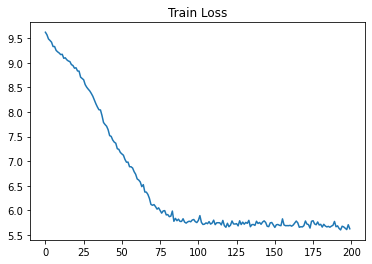

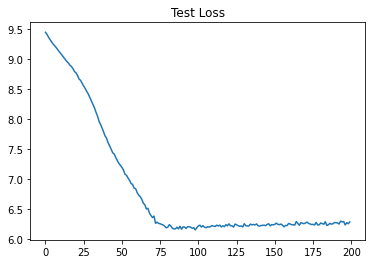

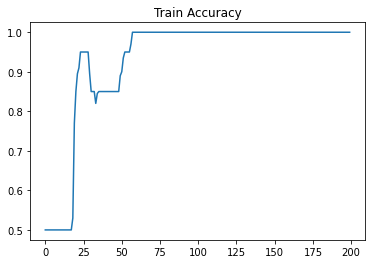

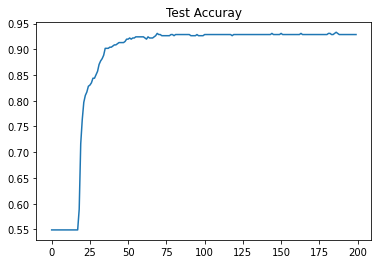

Active Learning Loop number: 1, Epoch: 201
[Train]		 J_a: 5.68, accuracy: 1.00
[Validation]	 J_a: 6.30, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 202
[Train]		 J_a: 5.74, accuracy: 1.00
[Validation]	 J_a: 6.32, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 203
[Train]		 J_a: 5.76, accuracy: 1.00
[Validation]	 J_a: 6.31, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 204
[Train]		 J_a: 5.68, accuracy: 1.00
[Validation]	 J_a: 6.28, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 205
[Train]		 J_a: 5.64, accuracy: 1.00
[Validation]	 J_a: 6.29, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 206
[Train]		 J_a: 5.70, accuracy: 1.00
[Validation]	 J_a: 6.30, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 207
[Train]		 J_a: 5.60, accuracy: 1.00
[Validation]	 J_a: 6.30, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 208
[Train]		 J_a: 5.67, accuracy: 1.00
[Validation]	 J_a: 6.28, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 209
[Trai

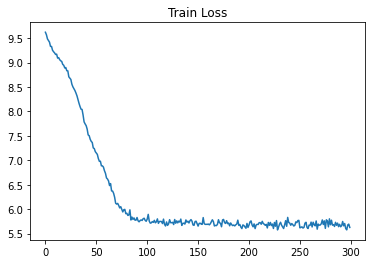

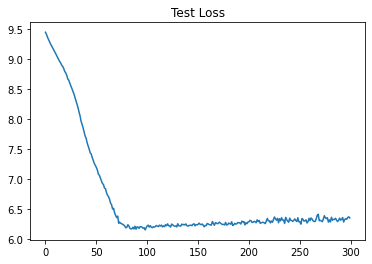

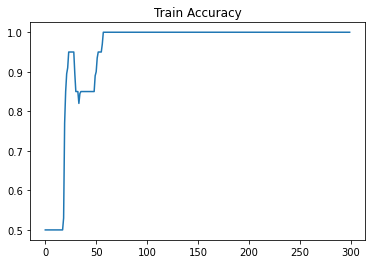

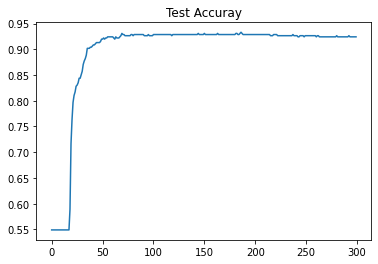

Active Learning Loop number: 1, Epoch: 301
[Train]		 J_a: 5.60, accuracy: 1.00
[Validation]	 J_a: 6.41, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 302
[Train]		 J_a: 5.71, accuracy: 1.00
[Validation]	 J_a: 6.33, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 303
[Train]		 J_a: 5.68, accuracy: 1.00
[Validation]	 J_a: 6.35, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 304
[Train]		 J_a: 5.64, accuracy: 1.00
[Validation]	 J_a: 6.29, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 305
[Train]		 J_a: 5.71, accuracy: 1.00
[Validation]	 J_a: 6.29, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 306
[Train]		 J_a: 5.64, accuracy: 1.00
[Validation]	 J_a: 6.34, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 307
[Train]		 J_a: 5.73, accuracy: 1.00
[Validation]	 J_a: 6.37, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 308
[Train]		 J_a: 5.65, accuracy: 1.00
[Validation]	 J_a: 6.33, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 309
[Trai

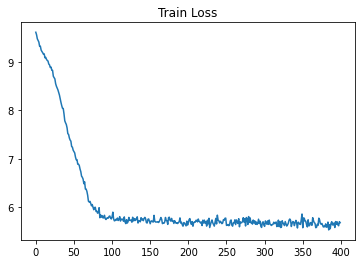

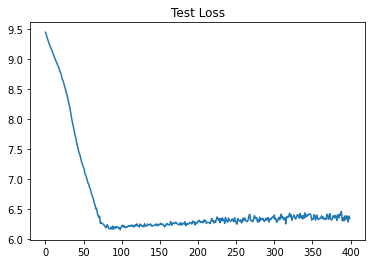

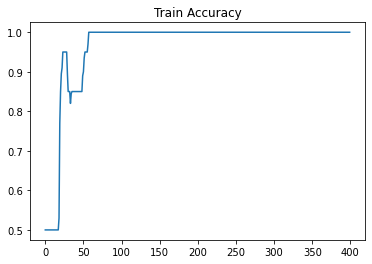

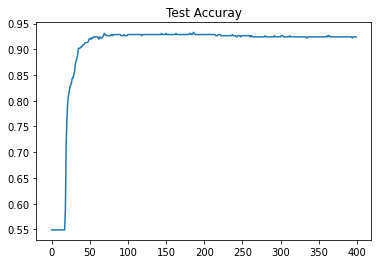

Active Learning Loop number: 1, Epoch: 401
[Train]		 J_a: 5.71, accuracy: 1.00
[Validation]	 J_a: 6.42, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 402
[Train]		 J_a: 5.67, accuracy: 1.00
[Validation]	 J_a: 6.42, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 403
[Train]		 J_a: 5.58, accuracy: 1.00
[Validation]	 J_a: 6.33, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 404
[Train]		 J_a: 5.64, accuracy: 1.00
[Validation]	 J_a: 6.36, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 405
[Train]		 J_a: 5.72, accuracy: 1.00
[Validation]	 J_a: 6.38, accuracy: 0.92
Active Learning Loop number: 1, Epoch: 406
[Train]		 J_a: 5.65, accuracy: 1.00
[Validation]	 J_a: 6.43, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 407
[Train]		 J_a: 5.68, accuracy: 1.00
[Validation]	 J_a: 6.37, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 408
[Train]		 J_a: 5.75, accuracy: 1.00
[Validation]	 J_a: 6.37, accuracy: 0.93
Active Learning Loop number: 1, Epoch: 409
[Trai

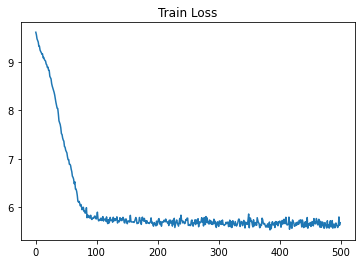

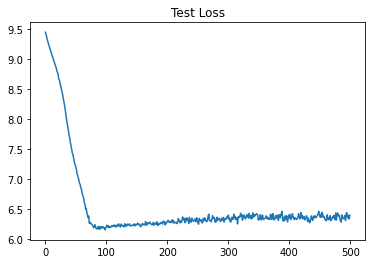

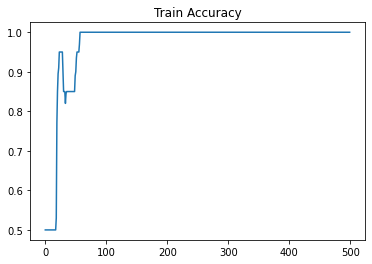

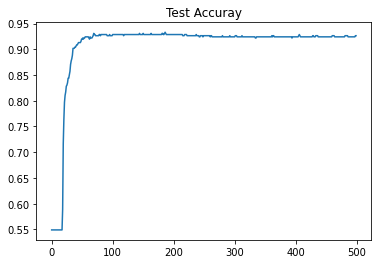

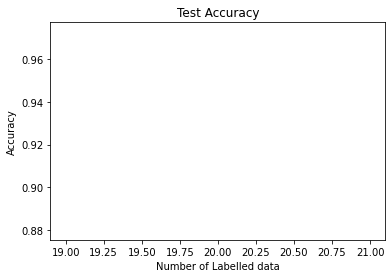

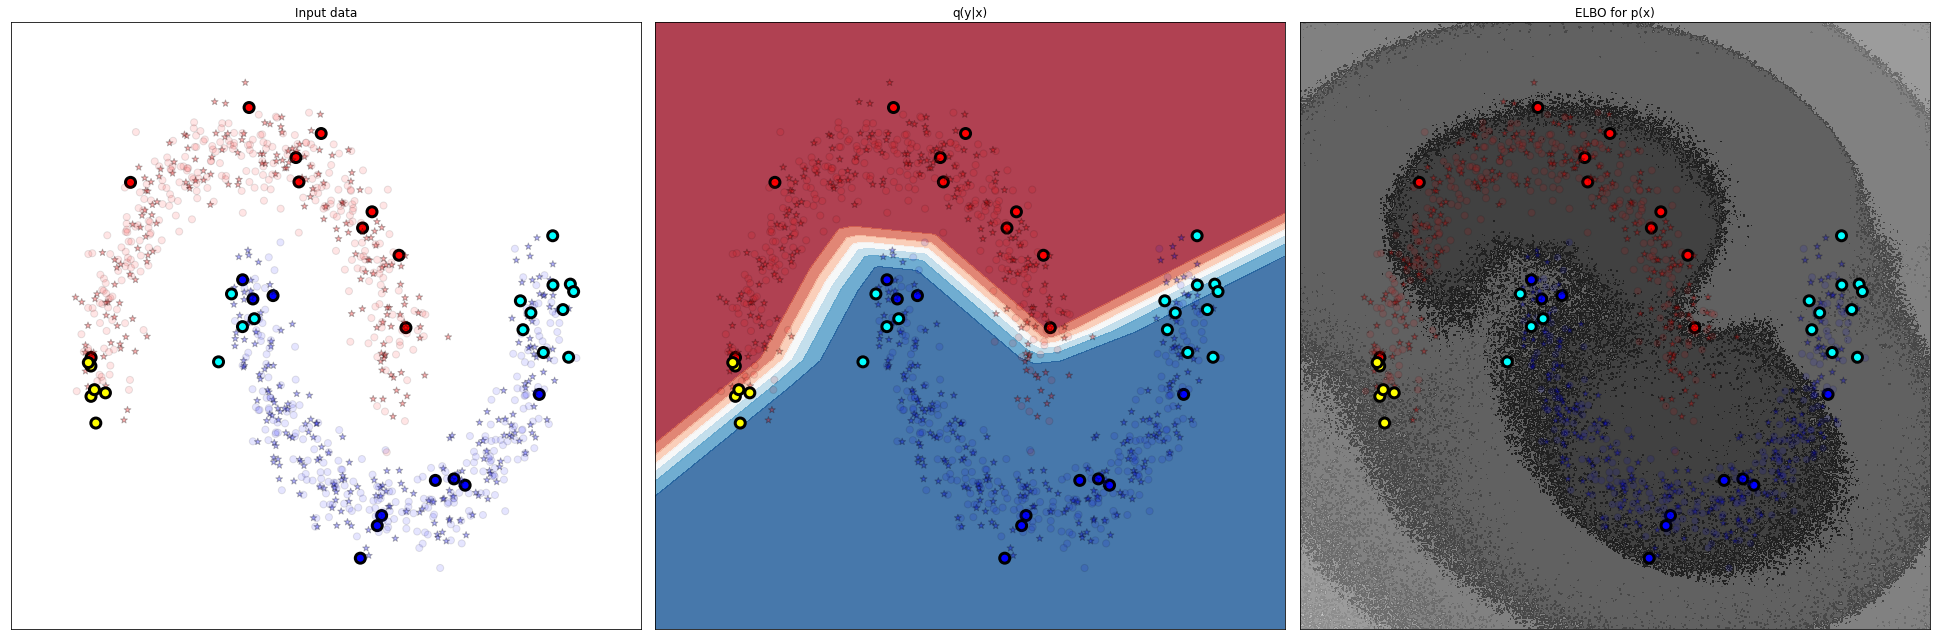

##################### AL Loop 2 #######################
Active Learning Loop number: 2, Epoch: 1
[Train]		 J_a: 10.53, accuracy: 0.60
[Validation]	 J_a: 10.18, accuracy: 0.55
Active Learning Loop number: 2, Epoch: 2
[Train]		 J_a: 10.49, accuracy: 0.60
[Validation]	 J_a: 10.15, accuracy: 0.55
Active Learning Loop number: 2, Epoch: 3
[Train]		 J_a: 10.45, accuracy: 0.60
[Validation]	 J_a: 10.12, accuracy: 0.55
Active Learning Loop number: 2, Epoch: 4
[Train]		 J_a: 10.41, accuracy: 0.60
[Validation]	 J_a: 10.09, accuracy: 0.55
Active Learning Loop number: 2, Epoch: 5
[Train]		 J_a: 10.37, accuracy: 0.60
[Validation]	 J_a: 10.05, accuracy: 0.55
Active Learning Loop number: 2, Epoch: 6
[Train]		 J_a: 10.34, accuracy: 0.60
[Validation]	 J_a: 10.02, accuracy: 0.55
Active Learning Loop number: 2, Epoch: 7
[Train]		 J_a: 10.29, accuracy: 0.60
[Validation]	 J_a: 9.99, accuracy: 0.55
Active Learning Loop number: 2, Epoch: 8
[Train]		 J_a: 10.26, accuracy: 0.60
[Validation]	 J_a: 9.96, accuracy:

In [0]:
# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
# labelled, unlabelled, validation = get_mnist(location="../data", batch_size=64, labels_per_class=10)
# labelled, unlabelled, validation, X_train, X_test, y_train, y_test, x_lab, y_lab, u_unlab, v_unlab = get_moons(batch_size=64, labels_per_class=20)

n_samples = 1000
labels_per_class = 10
valid_ratio = .4
training_data_size = n_samples * (1 - valid_ratio)

datasets = create_dataset(n_samples=n_samples, noise=0.1, random_state=0)
AL_data = ActiveMoon(datasets, use_cuda, valid_ratio=valid_ratio, batch_size=64, labels_per_class=labels_per_class)
validation = AL_data.get_valid()

epochs=500
acq_size = labels_per_class * 2

finished = False
acquired_idx = None
current_size = labels_per_class * 2
n_AL_loop = 0
test_accuracy_list=[]
training_size_list=[]

# Start Active Learning Loop
while not finished:
  n_AL_loop += 1
  print("##################### AL Loop {} #######################".format(n_AL_loop))

  labelled, unlabelled = AL_data.get_next_train(acquired_idx)
  X_train, X_test, y_train, y_test, x_lab, y_lab, u_unlab, v_unlab = AL_data.get_xyuv_for_printing(labelled, unlabelled)

  # alpha = 0.1 * len(unlabelled) / len(labelled)
  alpha = 0.1 * current_size

  model = M2(x_dim, y_dim, z_dim, h_en_dim, h_de_dim, h_cls_dim)
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
  if use_cuda: model = model.cuda()

  acquired_X, acquired_y, acquired_idx, test_accuracy = train_each_AL_loop(n_AL_loop, epochs, model, alpha, optimizer, labelled, unlabelled, validation, acq_size)
  test_accuracy_list.append(test_accuracy)
  training_size_list.append(current_size)


  # ---------------------------- Plot Accuracy --------------------------
  plt.title('Test Accuracy')
  plt.plot(training_size_list, test_accuracy_list)
  plt.ylabel('Accuracy')
  plt.xlabel('Number of Labelled data')
  plt.show()

  # ---------------------------- Plot boundary --------------------------
  h = .01  # step size in the mesh
  figure = plt.figure(figsize=(27, 9))
  i = 1

  x_min, x_max = min(X_train[:, 0].min(), X_test[:, 0].min()) - .5, max(X_train[:, 0].max(), X_test[:, 0].max()) + .5
  y_min, y_max = min(X_train[:, 1].min(), X_test[:, 1].min()) - .5, max(X_train[:, 1].max(), X_test[:, 1].max()) + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

  # just plot the dataset first
  cm = plt.cm.RdBu
  cm_elbo = plt.cm.Greys
  cm_bright = ListedColormap(['#FF0000', '#0000FF'])
  cm_new = ListedColormap(['#FFFF00', '#00FFFF'])
  ax = plt.subplot(1, 3, i)
  ax.set_title("Input data")
  # Plot the training points
  ax.scatter(x_lab[:, 0], x_lab[:, 1], c=y_lab, cmap=cm_bright, linewidths=3,
            edgecolors='k', s=100)
  ax.scatter(u_unlab[:, 0], u_unlab[:, 1], c=v_unlab, cmap=cm_bright,
            edgecolors='k', alpha=0.1, s=50)
  # Plot the testing points
  ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3,
            edgecolors='k', marker="*", s=50)
  # Plot the acquired points
  ax.scatter(acquired_X[:, 0], acquired_X[:, 1], c=acquired_y, cmap=cm_new, linewidths=3,
            edgecolors='k', s=100) 
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  ax.set_xticks(())
  ax.set_yticks(())
  i += 1

  # # iterate over classifiers
  # for name, clf in zip(names, classifiers):

  # ==================== Plot q(y|x) ==================
  ax = plt.subplot(1, 3, i)

  model.eval()
  boundary = np.c_[xx.ravel(), yy.ravel()]
  boundary = torch.from_numpy(boundary)
  boundary = Variable(boundary.float())
  if use_cuda:
    boundary = boundary.cuda()
  boundary_prob_y = model.classify(boundary)
  boundary_y = boundary_prob_y.data.cpu().numpy()[:,1]

  # Put the result into a color plot
  boundary_y = boundary_y.reshape(xx.shape)
  ax.contourf(xx, yy, boundary_y, cmap=cm, alpha=.8)

  # Plot the training points
  ax.scatter(x_lab[:, 0], x_lab[:, 1], c=y_lab, cmap=cm_bright, linewidths=3,
            edgecolors='k', s=100)
  ax.scatter(u_unlab[:, 0], u_unlab[:, 1], c=v_unlab, cmap=cm_bright,
            edgecolors='k', alpha=0.1, s=50)
  # Plot the testing points
  ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3,
            edgecolors='k', marker="*", s=50)
  # Plot the acquired points
  ax.scatter(acquired_X[:, 0], acquired_X[:, 1], c=acquired_y, cmap=cm_new, linewidths=3,
            edgecolors='k', s=100)

  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  ax.set_xticks(())
  ax.set_yticks(())
  # if ds_cnt == 0:
  ax.set_title("q(y|x)")
  # ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
  #         size=15, horizontalalignment='right')
  i += 1

  # ==================== Plot ELBO ==================
  ax = plt.subplot(1, 3, i)

  boundary_elbo_px = model(boundary, in_batch=False)
  boundary_elbo_px = boundary_elbo_px.data.cpu().numpy()
  # Put the result into a color plot
  boundary_elbo_px = boundary_elbo_px.reshape(xx.shape)
  ax.contourf(xx, yy, boundary_elbo_px, cmap=cm_elbo, alpha=.8)

  # Plot the training points
  ax.scatter(x_lab[:, 0], x_lab[:, 1], c=y_lab, cmap=cm_bright, linewidths=3,
            edgecolors='k', s=100)
  ax.scatter(u_unlab[:, 0], u_unlab[:, 1], c=v_unlab, cmap=cm_bright,
            edgecolors='k', alpha=0.1, s=50)
  # Plot the testing points
  ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3,
            edgecolors='k', marker="*", s=50)
  # Plot the acquired points
  ax.scatter(acquired_X[:, 0], acquired_X[:, 1], c=acquired_y, cmap=cm_new, linewidths=3,
            edgecolors='k', s=100)

  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  ax.set_xticks(())
  ax.set_yticks(())
  # if ds_cnt == 0:
  ax.set_title("ELBO for p(x)")
  # ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
  #         size=15, horizontalalignment='right')
  # i += 1




  plt.tight_layout()
  plt.show()
  # ===============================================================

  if acquired_idx is not None:
    current_size += len(acquired_idx)
  if acquired_idx is None:
    finished = True
